In [86]:
import pandas as pd
import numpy as np

np.random.seed(2022)

# Load water usage
waterusage = pd.read_csv("HistoricalWaterUseExpanded(1985-2015).csv")
# print(waterusage)

state_dict = ("AZ","CA","CO","NM","WY")
water_usage_ratio = (0.58211,0.13754,0.44553,0.12712,0.33077)

for i in range(0,waterusage.shape[0]):
    for j in state_dict:
        waterusage.loc[i,j] = np.multiply(waterusage.loc[i,j],water_usage_ratio[state_dict.index(j)])

waterusage = waterusage.set_index("year",drop=True)
print(waterusage)

               AZ           CA           CO          NM           WY
year                                                                
1985  4183.603937  5765.540994  6750.111121  467.601210  2296.781714
1986  4183.576514  5652.917304  6405.088925  472.874971  2444.271463
1987  4196.066616  5559.453386  6220.929880  478.775117  2571.365574
1988  4218.559090  5485.906521  6167.297401  484.888622  2676.015464
1989  4248.538784  5433.033992  6213.854901  490.802461  2756.172548
1990  4283.490546  5401.593082  6330.265794  496.103609  2809.788242
1991  4320.899223  5392.341072  6486.193494  500.379041  2834.813962
1992  4358.249665  5406.035246  6651.301416  503.215733  2829.201124
1993  4393.026717  5443.432884  6795.252973  504.200658  2790.901144
1994  4422.715229  5505.291270  6887.711580  502.920793  2717.865437
1995  4444.800048  5592.367686  6898.340651  498.963111  2608.045420
1996  4456.992280  5701.304244  6809.995209  492.229925  2462.567427
1997  4457.908066  5812.282377  66

In [87]:
# 放水量分析模型
L1_data = pd.read_csv("Upper Total water production(1985-2008).csv",index_col='date')
L2_data = pd.read_csv("lakepowell_monthlyrelease(1985-2015).csv",index_col='date')
L3_data = pd.read_csv("lakemead_monthlyrelease(1985-2015).csv",index_col='date')
Pdata = pd.read_csv("LakePowellMonthlyPoolElevation(feet,1985-2015).csv",index_col='date')
Mdata = pd.read_csv("LakeMeadMonthlyPoolElevation(feet,1985-2015).csv",index_col='date')

In [88]:
dataset = []
ans = []

def cubicmodel(elevation,lake):
    assert lake in ['powell','mead']
    if lake=="powell":
        return 0.498*elevation**3 - 1418 * elevation**2 + 1.4*10e6*elevation -4.73*10e8
    else: return 0.335*elevation**3 - 3353 * elevation**2 + 1.12*10e7*elevation -1.25*10e10
    

# 拟合数据准备
for years in range(1985,2009):
    for months in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
        datarow = []
        datarow.append(L1_data.loc[str(years)+"-"+str(months),'inflow'])
        datarow.append(cubicmodel(Pdata.loc[str(years)+"-"+str(int(months)),'pool elevation'],'powell')/1e6)
        for state in ("AZ","CO","NM","WY"):
            datarow.append(waterusage.loc[years,state]/12)
        dataset.append(datarow)
        ans.append(L2_data.loc[str(years)+"-"+str(int(months)),'release volume'])

Xdata = np.array(dataset)
Ydata = np.array(ans)

fitting model right now
Train ERROR =  45496.94340678839
Test ERROR =  27191.828882022437


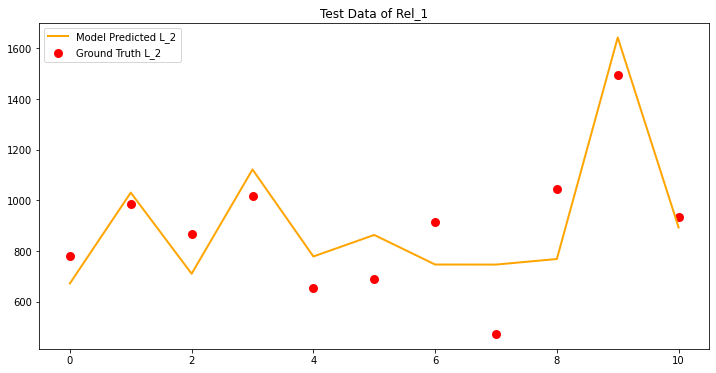

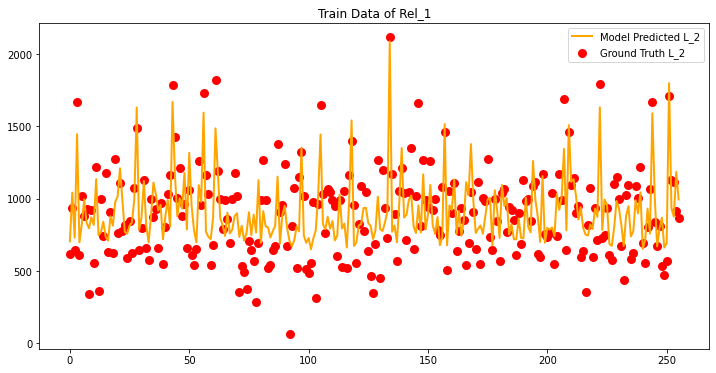

In [94]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

model = MLPRegressor()

# x_train, x_test, y_train, y_test = train_test_split(Xdata[:277,:],Ydata[:277], test_size = 0.04, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(Xdata[:267,:],Ydata[:267], test_size = 0.04, shuffle=True)

scaler = StandardScaler() # 标准化转换
scaler.fit(x_test)  # 训练标准化对象
x_test_Standard= scaler.transform(x_test)   # 转换数据集
scaler.fit(x_train)  # 训练标准化对象
x_train_Standard= scaler.transform(x_train)   # 转换数据集

fit1 = MLPRegressor(hidden_layer_sizes=(60,150,70),learning_rate_init=0.01, max_iter=10000)
print ("fitting model right now")
fit1.fit(x_train_Standard,y_train)
pred1_train = fit1.predict(x_train_Standard)

'''计算训练集 MSE'''
mse_1 = mean_squared_error(pred1_train,y_train)
print ("Train ERROR = ", mse_1)

'''计算测试集mse'''
pred1_test = fit1.predict(x_test_Standard)
mse_2 = mean_squared_error(pred1_test,y_test)
print ("Test ERROR = ", mse_2)
 
'''结果可视化'''
xx=range(0,len(y_test))
plt.figure(figsize=(12,6))
plt.scatter(xx,y_test,color="red",label="Ground Truth L_2",linewidth=3) 
plt.plot(xx,pred1_test,color="orange",label="Model Predicted L_2",linewidth=2)
plt.title("Test Data of Rel_1")
plt.legend()
plt.show()

xx=range(0,len(y_train))
plt.figure(figsize=(12,6))
plt.scatter(xx,y_train,color="red",label="Ground Truth L_2",linewidth=3) 
plt.plot(xx,pred1_train,color="orange",label="Model Predicted L_2",linewidth=2)
plt.title("Train Data of Rel_1")
plt.legend()
plt.show()

In [95]:
# 这一部分做L3数据的拟合
dataset = []
ans = []

for years in range(1985,2009):
    for months in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
        datarow = []
        datarow.append(L2_data.loc[str(years)+"-"+str(int(months)),'release volume'])
        datarow.append(cubicmodel(Mdata.loc[str(years)+"-"+str(int(months)),'pool elevation'],'mead')/1e6)
        datarow.append(waterusage.loc[years,'CA']/12)
        dataset.append(datarow)
        ans.append(L3_data.loc[str(years)+"-"+str(int(months)),'release volume'])

Xdata = np.array(dataset)
Ydata = np.array(ans)

fitting model right now
Train ERROR =  48163.236342783835
Test ERROR =  74450.53901483482


C:\Users\JHong\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


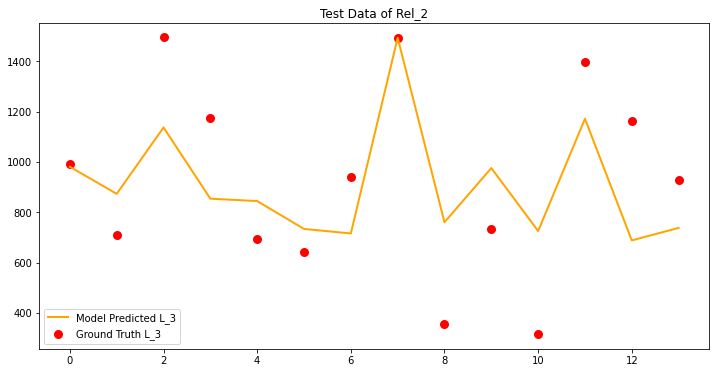

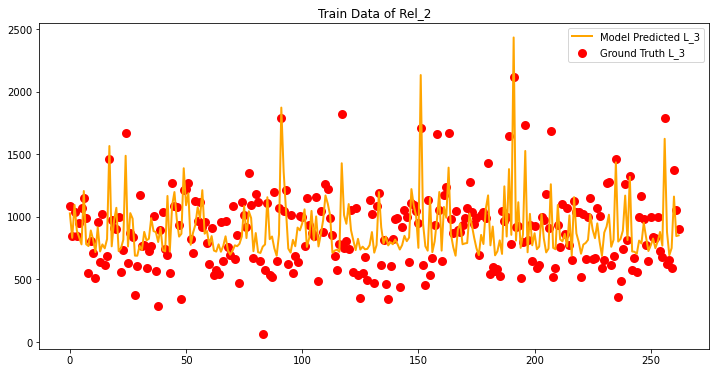

In [96]:
model = MLPRegressor()

# x_train, x_test, y_train, y_test = train_test_split(Xdata[:277,:],Ydata[:277], test_size = 0.05, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(Xdata[:277,:],Ydata[:277], test_size = 0.05, shuffle=True)

scaler = StandardScaler() # 标准化转换
scaler.fit(x_test)  # 训练标准化对象
x_test_Standard= scaler.transform(x_test)   # 转换数据集
scaler.fit(x_train)  # 训练标准化对象
x_train_Standard= scaler.transform(x_train)   # 转换数据集

fit1 = MLPRegressor(hidden_layer_sizes=(80,40,30),learning_rate_init=0.01,shuffle=False)
print ("fitting model right now")
fit1.fit(x_train_Standard,y_train)
pred1_train = fit1.predict(x_train_Standard)

'''计算训练集 MSE'''
mse_1 = mean_squared_error(pred1_train,y_train)
print ("Train ERROR = ", mse_1)

'''计算测试集mse'''
pred1_test = fit1.predict(x_test_Standard)
mse_2 = mean_squared_error(pred1_test,y_test)
print ("Test ERROR = ", mse_2)
 
'''结果可视化'''
xx=range(0,len(y_test))
plt.figure(figsize=(12,6))
plt.scatter(xx,y_test,color="red",label="Ground Truth L_3",linewidth=3) 
plt.plot(xx,pred1_test,color="orange",label="Model Predicted L_3",linewidth=2)
plt.title("Test Data of Rel_2")
plt.legend()
plt.show()

xx=range(0,len(y_train))
plt.figure(figsize=(12,6))
plt.scatter(xx,y_train,color="red",label="Ground Truth L_3",linewidth=3) 
plt.plot(xx,pred1_train,color="orange",label="Model Predicted L_3",linewidth=2)
plt.title("Train Data of Rel_2")
plt.legend()
plt.show()